<a href="https://colab.research.google.com/github/benmsanderson/SCM_MLtuner/blob/main/2_FAIR_EEI_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  import pickle
  targ=pickle.load( open( "/content/drive/MyDrive/faireei/targ.p", "rb" ) )
  obs=pickle.load(  open( "/content/drive/MyDrive/faireei/obs.p", "rb" ) )
  parammat=pickle.load(  open( "/content/drive/MyDrive/faireei/parammat.p", "rb" ) )
  obsunc=np.vstack([0.01,0.01,0.01,0.01,.1]).T
  wgts=[1,1,1,1,1]
  ndim = parammat.shape[1]
  wgts1=[0,0,1,0,1]
  wgts2=[0,0,1,1,1]
  wgts3=[2,2,1,1,1]

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.15.0
Num GPUs Available:  1


In [ ]:
def skillscore(targ,obs,obsunc,wgts):
  out=-np.sum((((obs-targ)/obsunc)**2)*wgts,axis=1)
  return out

In [ ]:
skillscore(targ,obs,obsunc,wgts)

array([-2030.62331365, -4397.6798242 ,  -989.98552152, ...,
       -1539.75271835,  -668.23513456, -1213.08511   ])

In [ ]:
nflds=targ.shape[1]

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(50, activation='tanh'),
      layers.Dense(10, activation='tanh'),
      layers.Dense(nflds)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
#normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer = tf.keras.layers.Normalization(input_shape=[parammat.shape[1],], axis=-1)

In [ ]:
normalizer.adapt(parammat)

In [ ]:
dnn_model = build_and_compile_model(normalizer)


In [ ]:
from sklearn.model_selection import train_test_split

XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building



In [ ]:
try:
    with tf.device('/device:XLA_GPU:0'):
        X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
        X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
        Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)
        #_model = tf.keras.Model(review_input, preds)
        #opt = optimizers.Adam()
        #_model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['acc'])
except RuntimeError as e:
  print(e)

In [ ]:
from tqdm.keras import TqdmCallback

In [ ]:
if 0:
    history=dnn_model.fit(X_train, Y_train, epochs=200000, batch_size=2000, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])
    dnn_model.save('/content/drive/MyDrive/faireei/dnn_model.keras')
else:
    dnn_model = keras.models.load_model('/content/drive/MyDrive/faireei/dnn_model.keras')



0epoch [00:00, ?epoch/s]

In [ ]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)


113/113 [==============================] - 0s 2ms/step


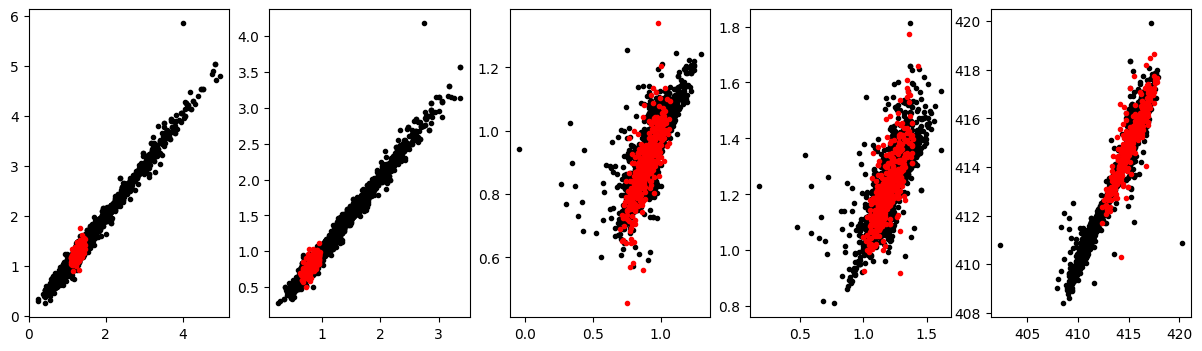

In [ ]:
fig, ax = pl.subplots(1, nflds, figsize=(15, 4))


for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],YValidation[:,i],'r.')




In [ ]:
    dnn_model.save('/content/drive/MyDrive/faireei/dnn_model.keras')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def log_prob(p,obs,obsunc,wgts):
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    out=skillscore(dnn_model.predict(p,verbose = 0),obs,obsunc,wgts).T
    out[np.isnan(out)]=-5e5
    out[np.abs(out)>5e5]=-5e5

    return out

In [ ]:
parammat.min(axis=0).shape

(47,)

In [ ]:
from scipy.stats import qmc
lhcs = qmc.LatinHypercube(d=ndim)
tmp = lhcs.random(n=5000000)
large_parammat = qmc.scale(tmp, parammat.min(axis=0), parammat.max(axis=0))

In [ ]:
pred_a = dnn_model.predict(large_parammat)


156250/156250 [==============================] - 204s 1ms/step


In [ ]:
score1=skillscore(pred_a,obs,obsunc,wgts1)
score2=skillscore(pred_a,obs,obsunc,wgts2)
score3=skillscore(pred_a,obs,obsunc,wgts3)



In [ ]:
p1=np.percentile(score1,99.98)
p2=np.percentile(score2,99.98)
p3=np.percentile(score3,99.98)


In [ ]:

wave1=large_parammat[score1>p1,:]
wave2=large_parammat[score2>p2,:]
wave3=large_parammat[score3>p3,:]


In [ ]:
wave1.shape

(1000, 47)

In [ ]:
pred1=pred_a[score1>p1,:]
pred2=pred_a[score2>p2,:]
pred3=pred_a[score3>p3,:]

In [ ]:
wave1.shape

(1000, 47)

In [ ]:
plt.plot(pred_a[:,0],pred_a[:,1],'.')
plt.plot(pred1[:,0],pred1[:,1],'y.')

plt.plot(pred3[:,0],pred3[:,1],'r.')


In [ ]:
wave1.shape

In [ ]:
  import pickle

  pickle.dump( wave1, open( "/content/drive/MyDrive/faireei/wave1.p", "wb" ) )
  pickle.dump( wave2, open( "/content/drive/MyDrive/faireei/wave2.p", "wb" ) )
  pickle.dump( wave3, open( "/content/drive/MyDrive/faireei/wave3.p", "wb" ) )

